<div style="display: flex; background-color: RGB(255,114,0); padding: 30px;" >

# La poste - création du modèle
</div>

In [1]:
import tensorflow as tf
from keras import layers, Sequential, Input
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.utils import plot_model
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from laposte_model_creation import *

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.1


In [2]:
verbose=0

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.Chargement des données
</div>

Pour ce projet, nous nous basons sur les données mnist

In [3]:
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = mnist.load_data()

<div style="display: flex; background-color: Green; padding: 7px;" >

### 1.1. Pré-processing
</div>

In [4]:
# Model / data parameters
num_classes = np.unique(y_train_origin).shape[0] # doit être 10
input_shape = (28, 28, 1)

In [5]:
# pré-processing
x_train, y_train = preprocess_data(x_train_origin, y_train_origin, nb_classes=num_classes, verbose=verbose)
x_test, y_test = preprocess_data(x_test_origin, y_test_origin, nb_classes=num_classes, verbose=verbose)
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


<div style="display: flex; background-color: Blue; padding: 15px;" >

## 2.Build the model
</div>

In [6]:
batch_size = 128
epochs = 5

In [ ]:
checkpoint_path = "model/cp.ckpt"
model_save_path = 'model/my_model'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

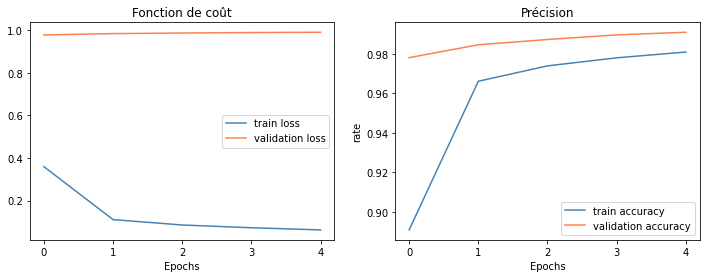

In [7]:
model3 = create_model(input_shape=input_shape, num_classes=num_classes)

if checkpoint_path is not None:
    checkpoint_dir = os.path.dirname(checkpoint_path)
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=verbose)
    
    # Save the weights using the `checkpoint_path` format
    model3.save_weights(checkpoint_path.format(epoch=0))

    history3 = model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[cp_callback])
else:
    history3 = model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

print(model3.evaluate(x_test,  y_test, verbose=2))
plot_history(history3.history,loss_name='loss', precision='accuracy', loss_val_name='val_loss', precision_val='val_accuracy')

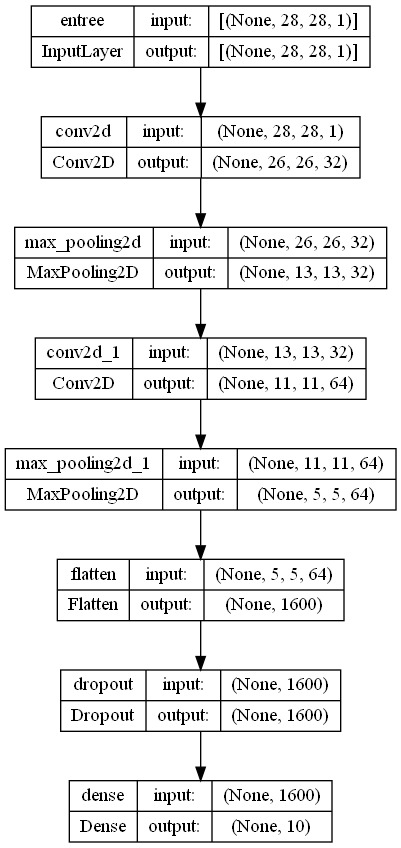

In [8]:
plot_model(model3, to_file=r"C:\Users\User\WORK\workspace-ia\PROJETS\projet_laposte\img\model3.png", show_shapes=True)

In [11]:
nb_tests = 5
predictions = model3(x_test[:nb_tests]).numpy()
print(predictions[0])
print(np.argmax(np.round(predictions[0], 2)))

[1.6292548e-08 1.5300200e-09 2.5013902e-05 1.1009817e-05 3.5110003e-12
 2.3150626e-09 7.3666388e-15 9.9996376e-01 2.6971325e-08 1.6818957e-07]
7


<div style="display: flex; background-color: indigo;" >

#### Visualisation prédictions
</div>

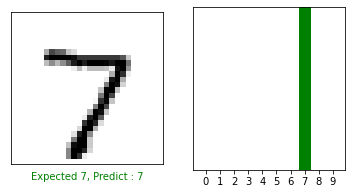

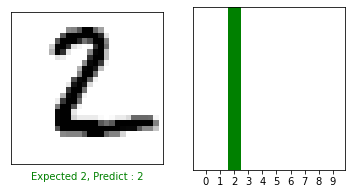

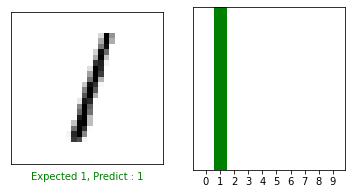

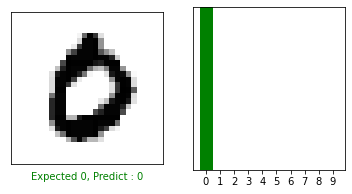

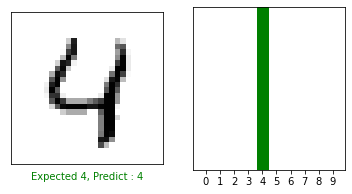

In [12]:
plot_pred(x=x_test, y=y_test, predictions=predictions, range=range(0,nb_tests))

<div style="display: flex; background-color: Green; padding: 7px;" >

### 1.2. Sauvegarde du modèle
</div>

https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
# Sauvegarde du modèle
if model_save_path is not None:
    # Save the entire model as a SavedModel.
    model3.save(model_save_path)

In [ ]:
# Chargement du modèle
if model_save_path is not None:

    # Create a basic model instance
    model_load = tf.keras.models.load_model(model_save_path)
    # Check its architecture
    print(model_load.summary())

    # Evaluate the restored model
    loss, acc = model_load.evaluate(x_test,  y_test, verbose=2)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print(model_load.predict(x_test).shape)

<div style="display: flex; background-color: Green; padding: 7px;" >

### 1.2. Optimize the model
</div>

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [14]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [16]:
# fix random seed for reproducibility
seed = 0
tf.random.set_seed(seed)

In [17]:
# create model
model_keras_classifier = KerasClassifier(model=create_model, verbose=verbose)

<div style="display: flex; background-color: indigo;" >

#### Tests paramètres autres
</div>

In [18]:
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model_keras_classifier, param_grid=param_grid, n_jobs=-1, cv=3)
grid = GridSearchCV(estimator=model_keras_classifier, param_grid=param_grid, cv=3)


grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1600)             

<div style="display: flex; background-color: indigo;" >

#### Tests optimizer
</div>

In [ ]:
model_opti = KerasClassifier(model=create_model, loss="binary_crossentropy", epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model_opti, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<div style="display: flex; background-color: Green; padding: 7px;" >

### 1.3. Graph model
</div>

- https://stackoverflow.com/questions/61427583/how-do-i-plot-a-keras-tensorflow-subclassing-api-model
- https://github.com/onnx/tensorflow-onnx
- https://github.com/lutzroeder/netron


In [ ]:
graph_function = tf.function(model3)